### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import matplotlib.pyplot as plt
import warnings
import os
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
import plotly.io as pio
from plotly.offline import plot , iplot ,init_notebook_mode
init_notebook_mode(connected=True)
%matplotlib inline

warnings.filterwarnings('ignore')


### Read available datasets

In [2]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
data = pd.read_excel(r'dataset\flow_data.xlsx')
data.head()

,timestamp,copy_mode,profile,total_runtime,status,records_processed,total_data_processed
0,20190819131549,LOCAL,SAP_UCSV,1290,FINISHED,30619937,2721723523
1,20190812065310,LOCAL,SAP_UCSV,1192,FINISHED,48666506,3902691720
2,20190902092042,LOCAL,SAP_UCSV,343,CANCELLED,32653243,2246436756
3,20190907063037,REMOTE,SAP_ALL,1800,FINISHED,60944409,5673935415
4,20190902064418,LOCAL,SAP_UCSV,249,CANCELLED,118175632,8857599641


In [3]:
data.shape

(362, 7)

In [4]:
# pd.set_option('display.precision',9)
settings_data = pd.read_excel(r'dataset\flow_settings.xlsx')
settings_data.head()

,timestamp,setting_name,setting_value
0,20191119080640,IGNORE_EXIT_ERRORS,X
1,20191119080640,IGNORE_TABLE_ERRORS,NaN
2,20191119080640,LOCK_SOURCE_CLIENT,NaN
3,20191119080640,PARALLEL_NUMBER,30
4,20191119080640,USE_EXCLUSIVE_LOCKS,X


#### Prepare and Join both datasets

In [5]:
settings_cleaned = settings_data.replace('X','SET')

In [6]:
flow_settings=pd.DataFrame(settings_cleaned.pivot(index='timestamp', columns='setting_name', values='setting_value')).reset_index().rename_axis(None, axis=1)
flow_settings.sample(5)

,timestamp,IGNORE_EXIT_ERRORS,IGNORE_TABLE_ERRORS,LOCK_SOURCE_CLIENT,PARALLEL_NUMBER,USE_EXCLUSIVE_LOCKS,USE_TABLE_SEGMENTER
190,20190605051543,NaN,NaN,NaN,7,NaN,NaN
228,20190619033036,SET,SET,NaN,10,NaN,NaN
302,20190801100732,SET,SET,SET,10,NaN,NaN
45,20190313050539,NaN,NaN,SET,15,NaN,NaN
139,20190513113001,NaN,NaN,SET,7,NaN,NaN


In [7]:
flow_settings.isna().sum()

timestamp                           0
IGNORE_EXIT_ERRORS                284
IGNORE_TABLE_ERRORS               402
LOCK_SOURCE_CLIENT                305
PARALLEL_NUMBER                     0
USE_EXCLUSIVE_LOCKS               355
USE_TABLE_SEGMENTER               484
dtype: int64

In [8]:
flow_settings = flow_settings.fillna(value = 'NOT_SET')

##### Lets join both tables

In [9]:
cc_data = data.join(flow_settings.set_index('timestamp'),on= 'timestamp',how='inner')
cc_data.head()

,timestamp,copy_mode,profile,total_runtime,status,records_processed,total_data_processed,IGNORE_EXIT_ERRORS,IGNORE_TABLE_ERRORS,LOCK_SOURCE_CLIENT,PARALLEL_NUMBER,USE_EXCLUSIVE_LOCKS,USE_TABLE_SEGMENTER
0,20190819131549,LOCAL,SAP_UCSV,1290,FINISHED,30619937,2721723523,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET
1,20190812065310,LOCAL,SAP_UCSV,1192,FINISHED,48666506,3902691720,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET
2,20190902092042,LOCAL,SAP_UCSV,343,CANCELLED,32653243,2246436756,NOT_SET,NOT_SET,SET,7,SET,NOT_SET
3,20190907063037,REMOTE,SAP_ALL,1800,FINISHED,60944409,5673935415,SET,SET,SET,10,NOT_SET,NOT_SET
4,20190902064418,LOCAL,SAP_UCSV,249,CANCELLED,118175632,8857599641,SET,NOT_SET,NOT_SET,6,SET,NOT_SET


In [10]:
cc_data.columns = map(str.lower,cc_data.columns)
cc_data.head()

,timestamp,copy_mode,profile,total_runtime,status,records_processed,total_data_processed,ignore_exit_errors,ignore_table_errors,lock_source_client,parallel_number,use_exclusive_locks,use_table_segmenter
0,20190819131549,LOCAL,SAP_UCSV,1290,FINISHED,30619937,2721723523,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET
1,20190812065310,LOCAL,SAP_UCSV,1192,FINISHED,48666506,3902691720,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET
2,20190902092042,LOCAL,SAP_UCSV,343,CANCELLED,32653243,2246436756,NOT_SET,NOT_SET,SET,7,SET,NOT_SET
3,20190907063037,REMOTE,SAP_ALL,1800,FINISHED,60944409,5673935415,SET,SET,SET,10,NOT_SET,NOT_SET
4,20190902064418,LOCAL,SAP_UCSV,249,CANCELLED,118175632,8857599641,SET,NOT_SET,NOT_SET,6,SET,NOT_SET


### Cleaning Data

In [11]:
# Lets see how many NaN values are present
cc_data.isna().sum()

timestamp                         0
copy_mode                         0
profile                           0
total_runtime                     0
status                            0
records_processed                 0
total_data_processed              0
ignore_exit_errors                0
ignore_table_errors               0
lock_source_client                0
parallel_number                   0
use_exclusive_locks               0
use_table_segmenter               0
dtype: int64

In [12]:
cc_data.columns

Index(['timestamp', 'copy_mode', 'profile', 'total_runtime', 'status',
       'records_processed', 'total_data_processed',
       'ignore_exit_errors            ', 'ignore_table_errors           ',
       'lock_source_client            ', 'parallel_number               ',
       'use_exclusive_locks           ', 'use_table_segmenter           '],
      dtype='object')

In [13]:
cc_data.columns = cc_data.columns.str.replace(' ', '')
cc_data.columns

Index(['timestamp', 'copy_mode', 'profile', 'total_runtime', 'status',
       'records_processed', 'total_data_processed', 'ignore_exit_errors',
       'ignore_table_errors', 'lock_source_client', 'parallel_number',
       'use_exclusive_locks', 'use_table_segmenter'],
      dtype='object')

In [14]:
cc_data['status'] = cc_data['status'].str.replace(" ","")
def remove_whitespace(x):
    try:
        # remove spaces inside and outside of string
        x = "".join(x.split())

    except:
        pass
    return x

# Apply remove_whitespace to column only
cc_data = cc_data.apply(remove_whitespace)
cc_data.status.value_counts()

FINISHED     281
CANCELLED     80
Name: status, dtype: int64

In [15]:
# import pandas_profiling
# pandas_profiling.ProfileReport(cc_data)

# Rename Columns
cc_data.rename(columns={'total_runtime':'runtime_in_seconds',
                        'total_data_processed' : 'size_in_bytes',
                       },
              inplace=True)
cc_data.drop(columns='timestamp',inplace=True)


In [16]:
cc_data.head()

,copy_mode,profile,runtime_in_seconds,status,records_processed,size_in_bytes,ignore_exit_errors,ignore_table_errors,lock_source_client,parallel_number,use_exclusive_locks,use_table_segmenter
0,LOCAL,SAP_UCSV,1290,FINISHED,30619937,2721723523,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET
1,LOCAL,SAP_UCSV,1192,FINISHED,48666506,3902691720,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET
2,LOCAL,SAP_UCSV,343,CANCELLED,32653243,2246436756,NOT_SET,NOT_SET,SET,7,SET,NOT_SET
3,REMOTE,SAP_ALL,1800,FINISHED,60944409,5673935415,SET,SET,SET,10,NOT_SET,NOT_SET
4,LOCAL,SAP_UCSV,249,CANCELLED,118175632,8857599641,SET,NOT_SET,NOT_SET,6,SET,NOT_SET


#### Adjust the datatypes

In [17]:
# Change to numeric columns
cc_data[['runtime_in_seconds','records_processed','size_in_bytes','parallel_number']] = \
cc_data[['runtime_in_seconds','records_processed','size_in_bytes','parallel_number']].apply(pd.to_numeric)


### Save the cleaned and processed Dataset

In [18]:
if not os.path.isfile('./dataset/copies_data_merged.csv'):
    
    cc_data.to_csv('./dataset/copies_data_merged.csv',index=None,header=True,)
cc_data.head()

,copy_mode,profile,runtime_in_seconds,status,records_processed,size_in_bytes,ignore_exit_errors,ignore_table_errors,lock_source_client,parallel_number,use_exclusive_locks,use_table_segmenter
0,LOCAL,SAP_UCSV,1290,FINISHED,30619937,2721723523,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET
1,LOCAL,SAP_UCSV,1192,FINISHED,48666506,3902691720,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET
2,LOCAL,SAP_UCSV,343,CANCELLED,32653243,2246436756,NOT_SET,NOT_SET,SET,7,SET,NOT_SET
3,REMOTE,SAP_ALL,1800,FINISHED,60944409,5673935415,SET,SET,SET,10,NOT_SET,NOT_SET
4,LOCAL,SAP_UCSV,249,CANCELLED,118175632,8857599641,SET,NOT_SET,NOT_SET,6,SET,NOT_SET


### Feature Engineering

We will try creating additional features from the current feature set (Columns) so that our Model and learn from these features for better predictions.
<br>
But before that let us examine the distribution for our numeric features

In [19]:
cols = pd.DataFrame(data = cc_data.dtypes , columns=['Datatype']).reset_index()
cols

,index,Datatype
0,copy_mode,object
1,profile,object
2,runtime_in_seconds,int64
3,status,object
4,records_processed,int64
5,size_in_bytes,int64
6,ignore_exit_errors,object
7,ignore_table_errors,object
8,lock_source_client,object
9,parallel_number,int64


In [20]:
cc_data.describe()

,runtime_in_seconds,records_processed,size_in_bytes,parallel_number
count,361,361,361,361
mean,4181,223259233,14423810028,8
std,41826,362906728,26216755498,5
min,13,0,0,0
25%,529,18329049,1534435820,6
50%,1334,89658494,6627857295,7
75%,2246,273542779,13405474528,10
max,795047,2178681778,158639896060,35


#### Distribution of records_processed

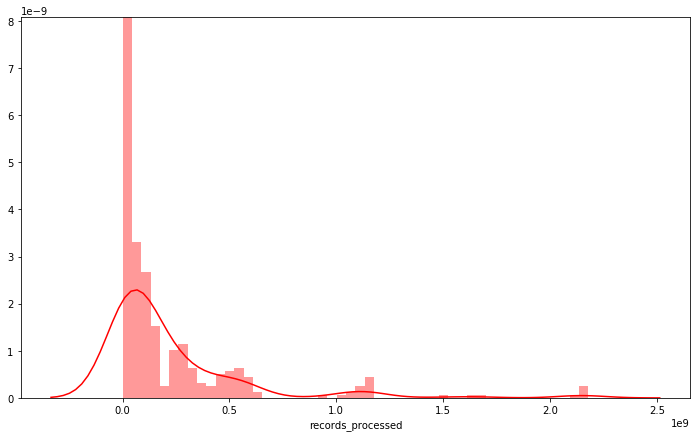

In [21]:
plt.figure(figsize=(12,7))
sns.distplot(cc_data['records_processed'],
             label = '1',
             color = 'red',
             bins=50,
             norm_hist=True,
            )
plt.show()

#### Feature Binning using Quantiles

 We will categorize the columns
 - __records_processed__ 
 - __size_in_bytes__
 <br>
 into multiple bins using the Quantile Information and create new features

In [22]:
cc_data[['records_processed','size_in_bytes']].describe()

,records_processed,size_in_bytes
count,361,361
mean,223259233,14423810028
std,362906728,26216755498
min,0,0
25%,18329049,1534435820
50%,89658494,6627857295
75%,273542779,13405474528
max,2178681778,158639896060


In [23]:
def get_quantile_category(data,quantile_labels):
    return pd.qcut(data,q=4,labels=quantile_labels)

In [24]:
quantile_labels = ['SMALL', 'MEDIUM', 'LARGE', 'XL']
cc_data['records_processed_category'] = get_quantile_category(cc_data.records_processed,quantile_labels)
cc_data['size_category'] = get_quantile_category(cc_data.size_in_bytes,quantile_labels)
cc_data.head()

,copy_mode,profile,runtime_in_seconds,status,records_processed,size_in_bytes,ignore_exit_errors,ignore_table_errors,lock_source_client,parallel_number,use_exclusive_locks,use_table_segmenter,records_processed_category,size_category
0,LOCAL,SAP_UCSV,1290,FINISHED,30619937,2721723523,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET,MEDIUM,MEDIUM
1,LOCAL,SAP_UCSV,1192,FINISHED,48666506,3902691720,SET,NOT_SET,NOT_SET,6,NOT_SET,NOT_SET,MEDIUM,MEDIUM
2,LOCAL,SAP_UCSV,343,CANCELLED,32653243,2246436756,NOT_SET,NOT_SET,SET,7,SET,NOT_SET,MEDIUM,MEDIUM
3,REMOTE,SAP_ALL,1800,FINISHED,60944409,5673935415,SET,SET,SET,10,NOT_SET,NOT_SET,MEDIUM,MEDIUM
4,LOCAL,SAP_UCSV,249,CANCELLED,118175632,8857599641,SET,NOT_SET,NOT_SET,6,SET,NOT_SET,LARGE,LARGE


#### Feature Interactions

Supervised machine learning models usually try to model the output responses (discrete classes or continuous values) as a function of the input feature variables. 
<br>
But before that let's see how the numeric features are varying.


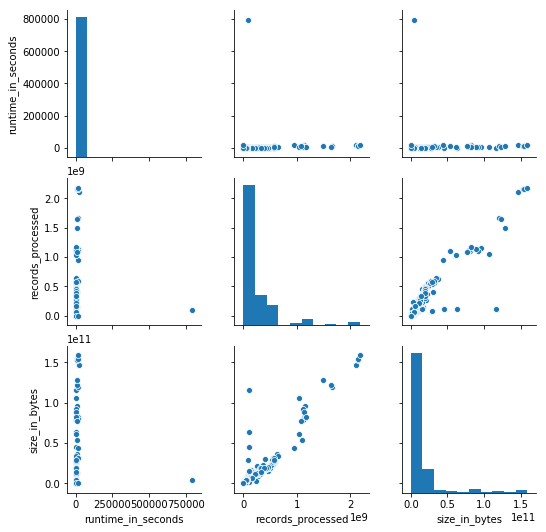

In [25]:
sns.pairplot(cc_data,vars=['runtime_in_seconds','records_processed','size_in_bytes'])

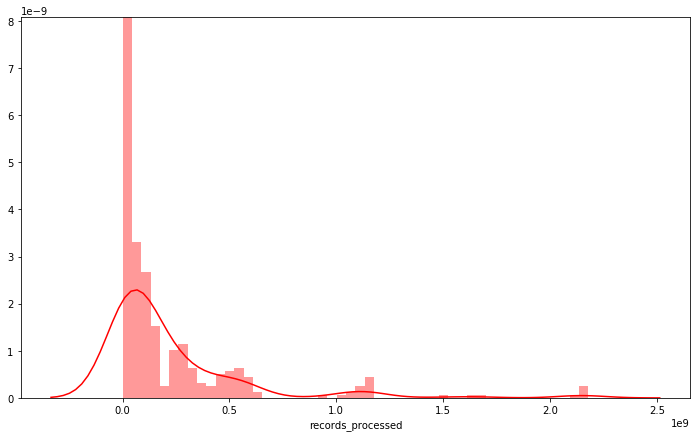

In [26]:
plt.figure(figsize=(12,7))
sns.distplot(cc_data['records_processed'],
             label = '1',
             color = 'red',
             bins=50
            )
plt.show()

#### Detecting Outliers

In [27]:
q1 = cc_data.quantile(.25)
q3 = cc_data.quantile(0.75)
iqr = q3-q1
print(iqr)

runtime_in_seconds          1717
records_processed      255213730
size_in_bytes        11871038708
parallel_number                4
dtype: float64


#### Remove Outliers

In [28]:
def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

final_df=cap_data(cc_data)

capping the  copy_mode
capping the  profile
capping the  runtime_in_seconds
capping the  status
capping the  records_processed
capping the  size_in_bytes
capping the  ignore_exit_errors
capping the  ignore_table_errors
capping the  lock_source_client
capping the  parallel_number
capping the  use_exclusive_locks
capping the  use_table_segmenter
capping the  records_processed_category
capping the  size_category


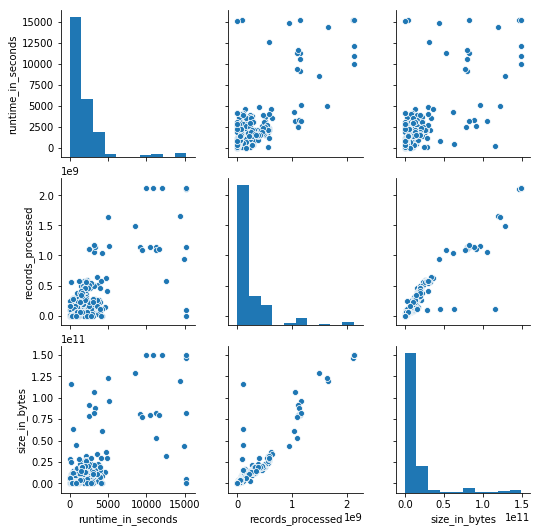

In [29]:
sns.pairplot(cc_data,vars=['runtime_in_seconds','records_processed','size_in_bytes'])

In [30]:
if not os.path.isfile('./dataset/cc_new_features_outliers_removed.csv'):
    final_df.to_csv('./dataset/cc_new_features_outliers_removed.csv',index=None,header=True,)
    final_df.head()

In [31]:
# Check the number of local client copy samples
final_df.copy_mode.value_counts()

LOCAL     273
REMOTE     32
CMPLCL     22
DELETE     12
SIZE        9
IMPORT      7
EXPORT      6
Name: copy_mode, dtype: int64

### Standardization & Handling Categorical variables

Earlier we replaced the NaN values in the settings variable (binary variables) to NOT_SET. 
- X       ---> SET
- (SPACE) ----> NOT_SET     

In [32]:
local_w_dummies = pd.get_dummies(final_df ,
                                 columns=[col for col in list(final_df.select_dtypes(include=['category','object']).columns
)
                                         ] 
)

cc_data.select_dtypes(include=['category','object']).columns
local_w_dummies.head()

,runtime_in_seconds,records_processed,size_in_bytes,parallel_number,copy_mode_CMPLCL,copy_mode_DELETE,copy_mode_EXPORT,copy_mode_IMPORT,copy_mode_LOCAL,copy_mode_REMOTE,...,use_table_segmenter_NOT_SET,use_table_segmenter_SET,records_processed_category_SMALL,records_processed_category_MEDIUM,records_processed_category_LARGE,records_processed_category_XL,size_category_SMALL,size_category_MEDIUM,size_category_LARGE,size_category_XL
0,1290,30619937,2721723523,6,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,1192,48666506,3902691720,6,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
2,343,32653243,2246436756,7,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
3,1800,60944409,5673935415,10,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,0,0
4,249,118175632,8857599641,6,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [33]:
if not os.path.isfile('./dataset/cc_cleaned_data_with_dummies.csv'):
    local_w_dummies.to_csv('./dataset/cc_cleaned_data_with_dummies.csv')

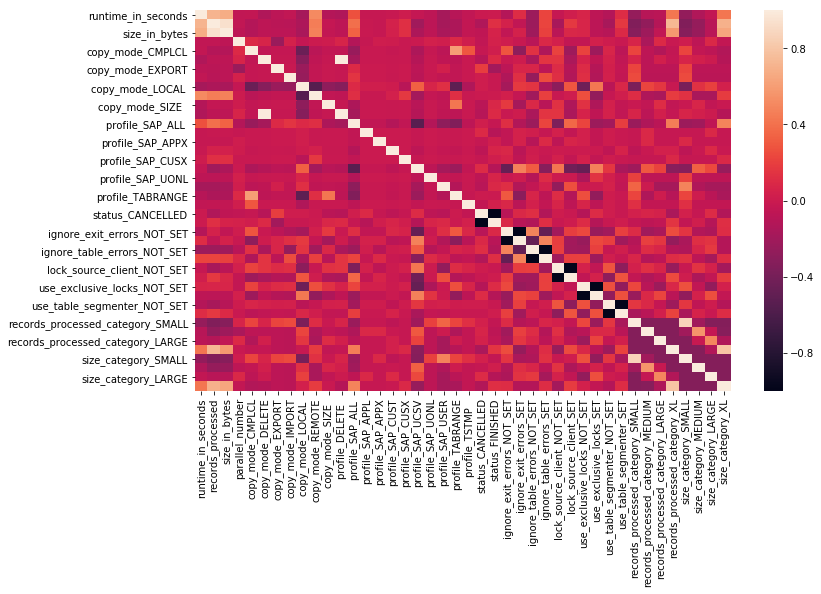

In [34]:
plt.figure(figsize=(12,7))
sns.heatmap(local_w_dummies.corr())

Lets separate the features and the target variables

In [35]:
target = pd.DataFrame(local_w_dummies.runtime_in_seconds)
features = local_w_dummies.drop(['runtime_in_seconds'],axis=1)

Now lets scale all numeric features

In [36]:
numeric_features = features.select_dtypes(include=['int64']).columns.tolist()

scaler = StandardScaler()
# scaler.fit(features[numeric_features])
# features[numeric_features]=scaler.transform(features[numeric_features])
# target = scaler.transform(target)

In [37]:
features.head()

,records_processed,size_in_bytes,parallel_number,copy_mode_CMPLCL,copy_mode_DELETE,copy_mode_EXPORT,copy_mode_IMPORT,copy_mode_LOCAL,copy_mode_REMOTE,copy_mode_SIZE,...,use_table_segmenter_NOT_SET,use_table_segmenter_SET,records_processed_category_SMALL,records_processed_category_MEDIUM,records_processed_category_LARGE,records_processed_category_XL,size_category_SMALL,size_category_MEDIUM,size_category_LARGE,size_category_XL
0,30619937,2721723523,6,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
1,48666506,3902691720,6,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
2,32653243,2246436756,7,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
3,60944409,5673935415,10,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
4,118175632,8857599641,6,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0


In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test , y_train , y_test = train_test_split(features ,target ,test_size = 0.3)

In [ ]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler_y = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [59]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xgbModel = xgb.XGBRegressor()
# xgbModel.fit(X_train ,y_train)
# y_xgb_predictions = xgbModel.predict(X_test)
# print(y_xgb_predictions)


In [60]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 15, 'alpha': 10}
dtrain_mat = xgb.DMatrix(X_train, y_train)
cv_results = xgb.cv(dtrain=dtrain_mat, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[01:54:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:54:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:54:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [61]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,3243,205,3244,460
1,3024,202,3038,467
2,2827,209,2862,472
3,2641,197,2712,476
4,2486,179,2594,481


In [62]:
print((cv_results["test-rmse-mean"]).tail(1))
# predictions = [round(value) for value in y_xgb_predictions]
# rmse = np.sqrt(mean_squared_error(y_test,y_xgb_predictions))

49   1778
Name: test-rmse-mean, dtype: float64


In [45]:
# print("RMSE: %f" % (rmse))

In [63]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression(fit_intercept=False)
regressor.fit(X_train ,y_train)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [64]:
linear_preds=regressor.predict(X_test)

In [65]:
from sklearn.metrics import r2_score
r2_score(y_test,linear_preds)

0.4406681666064136

In [66]:
regressor.score(X_test,y_test)

0.44066816660641356

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

xgb_pipeline = Pipeline([("xgbmod", xgb.XGBRFRegressor())])
xgb_param_grid = {'xgbmod__subsample': np.arange(.05,.1,.05),
                  'xgbmod__objective': ['reg:linear'],
                  'xgbmod__max_depth': np.arange(3,20,1),
                  'xgbmod__colsample_bytree':np.arange(0.1,1.05,0.05),
                  'xgbmod__learning_rate':np.arange(0.05 ,1 ,0.05),
                  'xgbmod__n_estimators':np.arange(50,200 ,50)}
search = RandomizedSearchCV(estimator=xgb_pipeline,
                            param_distributions=xgb_param_grid,
                            n_iter=10,
                            cv=9,
#                             verbose=1,
                            n_jobs =-1,
                            scoring='r2',
                            return_train_score=True)
search.fit(X_train,y_train)

[01:55:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=9, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('xgbmod',
                                              XGBRFRegressor(base_score=0.5,
                                                             colsample_bylevel=1,
                                                             colsample_bynode=0.8,
                                                             colsample_bytree=1,
                                                             gamma=0,
                                                             learning_rate=1,
                                                             max_delta_step=0,
                                                             max_depth=3,
                                                             min_child_weight=1,
                                                             missing=None,
                                                             n_estimato

In [68]:
search.best_score_

0.02112927779355452

In [52]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


In [53]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

0.5199103116566745
0.7296932678330597
1.0901329751335285
0.4681625683384001


In [54]:
m_svr = SVR()
m_svr.fit(X_train, y_train) 
pred_train_rr= m_svr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= m_svr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

0.5151181415680376
0.7346533002274913
1.1564532870162838
0.40148348729650385


In [55]:
m_rr = RandomForestRegressor()
m_rr.fit(X_train, y_train) 
pred_train_rr= m_rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= m_rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

0.2558973282090192
0.9345165574154854
1.0890526891699093
0.4692161129096517


In [56]:
from sklearn.model_selection import GridSearchCV
random_regressor = RandomForestRegressor()
parameters = { 'max_features':np.arange(5,10),
              'n_estimators':[500],
              'min_samples_leaf': [10,50,100,200,500],
              'max_depth': [5,10,15]}
random_grid = GridSearchCV(random_regressor, parameters, cv = 5)
random_grid.fit(X_train, y_train)
pred_test_rr= random_grid.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

1.1892822306628326
0.3670202635799391


In [57]:
# Hyper parameter Tuning Ridge Regression
ridge = Ridge()
parameters = {'alpha':[0.01, 0.024, 0.025, 0.026, 0.03]}
random_grid = GridSearchCV(ridge, parameters, cv = 9)
random_grid.fit(X_train, y_train)
pred_test_ridge= random_grid.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_ridge))) 
print(r2_score(y_test, pred_test_ridge))

1.0900890525097116
0.46820542407321764


#### Adding Polynomial Features

As seen from the plot between size and records processed a straight line cannot capture the patterns in the data. 
This is __under-fitting__ . <br>
To overcome under-fitting, we need to increase the complexity of the model

In [ ]:
poly = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
poly_features = poly